In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import label_binarize
from sklearn.cross_validation import train_test_split

from sklearn.metrics import roc_auc_score, roc_curve, classification_report, auc, confusion_matrix

import xgboost as xgb
import cPickle as pickle

from string import punctuation
from nltk import word_tokenize
from nltk.stem import snowball

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')

stemmer = snowball.SnowballStemmer("english")
%matplotlib inline

In [8]:
def load_data(filename='labeledhate_pyladies.p'):
    '''
    Load data into a data frame for use in running model
    '''
    return pickle.load(open(filename, 'rb'))


def stem_tokens(tokens, stemmer):
    '''Stem the tokens.'''
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed


def tokenize(text):
    '''Tokenize & stem. Stems automatically for now.
    Leaving "stemmer" out of function call, so it works with TfidfVectorizer'''
    tokens = word_tokenize(text)
    stems = stem_tokens(tokens, stemmer)
    return stems


def splitdata(X, y, classes, test_size=0.3):
    '''
    Split data into test & train; binarizes y into 5 classes
    Outputs: X_train, X_test, y_train, y_test
    '''

    #relabel y labels to reflect integers [0-4] for xgboost
    for ind in range(len(classes)):
        y[(y==classes[ind])] = int(ind)

    return train_test_split(X, y, test_size=test_size, random_state=42)


def createmulticlassROC(classes, y_test, y_score):
    '''
    Function to create & plot ROC curve & associated areas
    Adapted from http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

    Inputs: classes: a list of classes
            y_test: the test labels, binarized into columns
            y_score: the predicted probabilities for each class.
                (e.g. y_score = classifier.fit(countv_fit_X_train, y_train).predict_proba(countv_fit_X_test) )
    '''

    # Compute ROC curve and ROC area for each class
    n_classes = len(classes)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    # plt.figure(figsize = (12,8))
    plt.figure()

    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                       ''.format(classes[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for multi-class')
    plt.legend(loc="lower right")
    # plt.show()
    
    
def top_features_words(d,vect, n=20):
    '''
    Function to show the top n important features, their scores,and corresponding words.
    The get_fscore method in xgboost returns a dictionary of features & a number.
    Get the top n features with the highest scores

    d is a dictionary (from bst.get_fscore() in xgboost)
    vect is the instantiated vectorizer (e.g. vect = TfidfVectorizer(stuff); not the fitted variable name)
    '''
    try:
        # Back out important features
        dicta = vect.vocabulary_
        dictb = dict ( (v,k) for k, v in dicta.items() )
        # dictb[featurenum] returns the word.

        featureslist = []
        for k, v in sorted(d.iteritems(), reverse=True, key=lambda (k,v): (v,k)):
            featureslist.append((k,v))

        topfeatures = []
        for i in xrange(n):
            fname = featureslist[i][0]
            fnum=int(filter(lambda x: x.isdigit(),fname))
            topfeatures.append((featureslist[i][0],featureslist[i][1],dictb[fnum]))

        return topfeatures

    except:
        pass


In [9]:
classes = ['NotHate', 'SizeHate', 'GenderHate', 'RaceHate', 'ReligionHate']
print('Loading Data')
df = load_data()
X = df.body
# strip puctuation from X
X = X.apply(lambda x: ''.join([l for l in x if l not in punctuation]))
y = df.label

X_train, X_test, y_train, y_test = splitdata(X, y, classes)

Loading Data


In [10]:
#relabel the output for multiclass roc plot, score
ytest_bin = label_binarize(y_test.astype(int), classes=[0,1,2,3,4],sparse_output=False)

In [66]:
type(ytest_bin[0][0])

numpy.int64

In [115]:
y_test.astype(int)

490085     0
1394221    0
268654     1
644443     0
1442813    0
1264539    0
999715     0
1113007    0
1208920    0
1142385    0
1420250    0
46688      3
41708      3
256613     1
708470     0
696873     0
1361746    0
170163     1
322526     1
123732     1
1141311    0
131170     1
1006682    0
701852     0
1127720    0
1144042    0
1250727    0
139792     1
1152387    0
199309     1
          ..
1338767    0
1221692    0
239450     1
359496     1
786222     0
954183     0
929855     0
1003594    0
1435683    0
646567     0
1355519    0
1028366    0
722248     0
1045499    0
646159     0
410835     1
271573     1
76630      2
406159     1
1069092    0
940019     0
1040366    0
416743     1
1015242    0
172324     1
1331909    0
1363644    0
1071253    0
619876     0
1195615    0
Name: label, dtype: int64

In [19]:
# # WARNING - takes ~10? min to run -- better to open vect_pyladies.p!
vect = TfidfVectorizer(decode_error = 'ignore', stop_words = 'english', tokenizer=tokenize)

tfidf_X_train = vect.fit_transform(X_train)
tfidf_X_test = vect.transform(X_test)

# # Save out vect
pickle.dump(vect, open('vect_pyladies.p', 'wb'))


# Load saved vect with
vect = pickle.load(open('vect_pyladies.p', 'rb'))

In [20]:
xg_train = xgb.DMatrix(tfidf_X_train, label=y_train)
xg_test = xgb.DMatrix(tfidf_X_test, label=y_test)

In [22]:
# Set up xboost parameters
# use softmax multi-class classification to return probabilities
param = {'objective': 'multi:softprob',
         'eta': 0.9,
         'max_depth': 6,
         'num_class': 5
         }
watchlist = [ (xg_train, 'train'), (xg_test, 'test') ]
num_round = 50  # Artificially small -- we'll have a crappy model. Set to ~400 or 450.
evals_result_dict = {}
bst = xgb.train(param, xg_train, num_round, watchlist, early_stopping_rounds=5, evals_result=evals_result_dict)

# Save the model
bst.save_model('hatepredictor_pyladies.model')

# # to load a saved xgboost model:
# bst = xgb.Booster()
# bst.load_model('hatepredictor_pyladies.model')

Will train until test error hasn't decreased in 5 rounds.
[0]	train-merror:0.253487	test-merror:0.255405
[1]	train-merror:0.248415	test-merror:0.250559
[2]	train-merror:0.245400	test-merror:0.248646
[3]	train-merror:0.241545	test-merror:0.245593
[4]	train-merror:0.237187	test-merror:0.240793
[5]	train-merror:0.233636	test-merror:0.238494
[6]	train-merror:0.231161	test-merror:0.236241
[7]	train-merror:0.229470	test-merror:0.235119
[8]	train-merror:0.226948	test-merror:0.233077
[9]	train-merror:0.225675	test-merror:0.232287
[10]	train-merror:0.224256	test-merror:0.231330
[11]	train-merror:0.222746	test-merror:0.230420
[12]	train-merror:0.221978	test-merror:0.229785
[13]	train-merror:0.220331	test-merror:0.228397
[14]	train-merror:0.219306	test-merror:0.227891
[15]	train-merror:0.217718	test-merror:0.226493
[16]	train-merror:0.216299	test-merror:0.225620
[17]	train-merror:0.215183	test-merror:0.224875
[18]	train-merror:0.214352	test-merror:0.224360
[19]	train-merror:0.213548	test-merror:0

In [58]:
# get prediction - this is in a 1D array, need reshape to (ndata, nclass)
y_proba = bst.predict(xg_test).reshape(y_test.shape[0], 5)
y_pred_ind = np.argmax(y_proba, axis=1)

In [59]:
y_pred_ind
len(y_pred_ind)  #108745

array([0, 0, 0, ..., 0, 0, 0])

In [80]:
# Didn't need...

# # Write out predictions in 1 or 0 format
# y_preds = np.zeros_like(y_proba, dtype=np.int64)

# for i in range(len(y_preds)):
#     y_preds[i][y_pred_ind[i]] = 1
    

In [96]:
y_pred_ind

array([0, 0, 0, ..., 0, 0, 0])

In [90]:
y_preds

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       ..., 
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0]])

(array([  9.33080000e+04,   0.00000000e+00,   1.22900000e+04,
          0.00000000e+00,   0.00000000e+00,   1.58500000e+03,
          0.00000000e+00,   1.50400000e+03,   0.00000000e+00,
          5.80000000e+01]),
 array([ 0. ,  0.4,  0.8,  1.2,  1.6,  2. ,  2.4,  2.8,  3.2,  3.6,  4. ]),
 <a list of 10 Patch objects>)

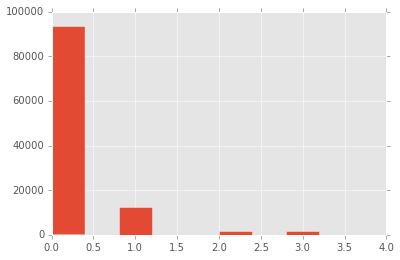

In [91]:
# distribution of indices
plt.hist(y_pred_ind)

In [170]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0, vmax=15000)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [117]:
y_test_int = y_test.astype(int)

In [136]:
y_test_array = np.array(y_test_int)

In [119]:
y_pred_ind.dtype

dtype('int64')

In [128]:
y_pred_ind

array([0, 0, 0, ..., 0, 0, 0])

(array([  9.33080000e+04,   1.22900000e+04,   1.58500000e+03,
          1.50400000e+03,   5.80000000e+01]),
 array([ 0. ,  0.8,  1.6,  2.4,  3.2,  4. ]),
 <a list of 5 Patch objects>)

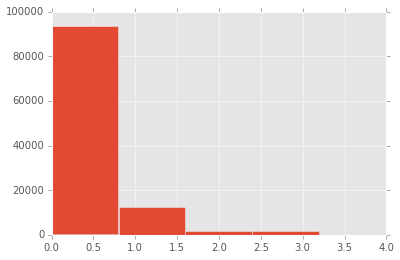

In [148]:
# plt.hist(y_test_array, bins=5)
plt.hist(y_pred_ind, bins=5)

In [145]:
# y_test_array
y_pred_ind

array([0, 0, 0, ..., 0, 0, 0])

In [181]:
cm = confusion_matrix(y_test_array, y_pred_ind)
print cm

[[73318  2328   272   181     4]
 [13851  9616   103    60     3]
 [ 3233   203  1142    36     8]
 [ 2561   133    46  1199    21]
 [  345    10    22    28    22]]


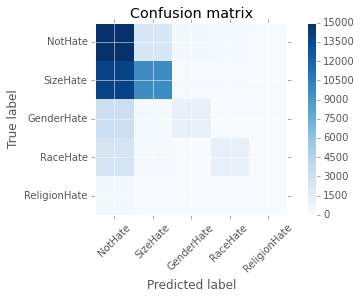

In [171]:
figure = plt.Figure(figsize=(12, 12))
plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues)